In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum, count, avg, round, udf, corr
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, IndexToString, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import VectorUDT


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
spark = SparkSession.builder\
    .appName("Préparation de données")\
    .enableHiveSupport()\
    .getOrCreate()

spark.sparkContext.setLogLevel("OFF")
spark.catalog.clearCache()
spark.sql("USE concessionnaire")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/18 09:47:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/18 09:47:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/11/18 09:47:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


DataFrame[]

In [3]:
clients_immatriculations = spark.sql("SELECT * FROM clients_immatriculations")
clients_immatriculations.printSchema()

root
 |-- immatriculation: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: double (nullable = true)
 |-- situationfamiliale: string (nullable = true)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: boolean (nullable = true)
 |-- taux_eligible: boolean (nullable = true)
 |-- marque: string (nullable = true)
 |-- modele: string (nullable = true)
 |-- puissance: integer (nullable = true)
 |-- longueur: string (nullable = true)
 |-- nbplaces: integer (nullable = true)
 |-- nbportes: integer (nullable = true)
 |-- couleur: string (nullable = true)
 |-- occasion: boolean (nullable = true)
 |-- prix: integer (nullable = true)
 |-- categorie: string (nullable = true)



### Verification des doublons

In [4]:
doublons = clients_immatriculations.groupBy(*clients_immatriculations.columns).agg(count("*").alias("count")).filter("count > 1")
doublons.show(truncate=False)

+---------------+---+----+----+------------------+---------------+---------------+-------------+------+------+---------+--------+--------+--------+-------+--------+----+---------+-----+
|immatriculation|age|sexe|taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|marque|modele|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|categorie|count|
+---------------+---+----+----+------------------+---------------+---------------+-------------+------+------+---------+--------+--------+--------+-------+--------+----+---------+-----+
+---------------+---+----+----+------------------+---------------+---------------+-------------+------+------+---------+--------+--------+--------+-------+--------+----+---------+-----+



### Analyse des **null**

In [5]:
from pyspark.sql.functions import col, when, sum

null_counts = clients_immatriculations.select(
    *[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in clients_immatriculations.columns]
)

null_counts_dict = null_counts.collect()[0].asDict()

columns_with_nulls = [(col_name, count) for col_name, count in null_counts_dict.items() if count > 0]

nulls_df = spark.createDataFrame(columns_with_nulls, ["Column", "Null Count"])

nulls_df.show()

+---------------+----------+
|         Column|Null Count|
+---------------+----------+
|nbenfantacharge|       190|
+---------------+----------+



In [6]:
clients_immatriculations = clients_immatriculations.fillna(0)

### Supprimer les colones innutiles

In [7]:
clients_immatriculations = clients_immatriculations.drop('immatriculation')

### OneHotEncoder

In [8]:
indexer_marque = StringIndexer(inputCol="marque", outputCol="marque_index")
indexer_marque = indexer_marque.fit(clients_immatriculations)
clients_immatriculations = indexer_marque.transform(clients_immatriculations)

encoder_marque = OneHotEncoder(inputCol="marque_index", outputCol="marque_encoded")
clients_immatriculations = encoder_marque.fit(clients_immatriculations).transform(clients_immatriculations)

In [9]:
indexer_sexe = StringIndexer(inputCol="sexe", outputCol="sexe_index")
indexer_sexe = indexer_sexe.fit(clients_immatriculations)
clients_immatriculations = indexer_sexe.transform(clients_immatriculations)

encoder_sexe = OneHotEncoder(inputCol="sexe_index", outputCol="sexe_encoded")
clients_immatriculations = encoder_sexe.fit(clients_immatriculations).transform(clients_immatriculations)

In [10]:
indexer_couleur = StringIndexer(inputCol="couleur", outputCol="couleur_index")
indexer_couleur = indexer_couleur.fit(clients_immatriculations)
clients_immatriculations = indexer_couleur.transform(clients_immatriculations)

In [11]:
indexer_situationfamiliale = StringIndexer(inputCol="situationfamiliale", outputCol="situationfamiliale_index")
indexer_situationfamiliale = indexer_situationfamiliale.fit(clients_immatriculations)
clients_immatriculations = indexer_situationfamiliale.transform(clients_immatriculations)

encoder_situationfamiliale = OneHotEncoder(inputCol="situationfamiliale_index", outputCol="situationfamiliale_encoded")
clients_immatriculations = encoder_situationfamiliale.fit(clients_immatriculations).transform(clients_immatriculations)

In [12]:
clients_immatriculations = clients_immatriculations.drop('marque') 
clients_immatriculations = clients_immatriculations.drop('marque_index')
clients_immatriculations = clients_immatriculations.drop('sexe') 
clients_immatriculations = clients_immatriculations.drop('sexe_index')
clients_immatriculations = clients_immatriculations.drop('couleur') 
clients_immatriculations = clients_immatriculations.drop('situationfamiliale') 
clients_immatriculations = clients_immatriculations.drop('situationfamiliale_index')

clients_immatriculations = clients_immatriculations.withColumnRenamed('marque_encoded', 'marque')
clients_immatriculations = clients_immatriculations.withColumnRenamed('sexe_encoded', 'sexe')
clients_immatriculations = clients_immatriculations.withColumnRenamed('couleur_indexed', 'couleur')
clients_immatriculations = clients_immatriculations.withColumnRenamed('situationfamiliale_encoded', 'situationfamiliale')

## Changer des Boolean en Int

In [13]:
clients_immatriculations = clients_immatriculations.withColumn(
    "deuxiemevoiture",
    when(col("deuxiemevoiture") == False, 0)
    .when(col("deuxiemevoiture") == True, 1)
    .otherwise(col("deuxiemevoiture").cast("int"))
)

clients_immatriculations = clients_immatriculations.withColumn(
    "taux_eligible",
    when(col("taux_eligible") == False, 0)
    .when(col("taux_eligible") == True, 1)
    .otherwise(col("taux_eligible").cast("int"))
)

clients_immatriculations = clients_immatriculations.withColumn(
    "occasion",
    when(col("occasion") == False, 0)
    .when(col("occasion") == True, 1)
    .otherwise(col("occasion").cast("int"))
)

clients_immatriculations.show(4)

+----+-----+---------------+---------------+-------------+----------------+---------+-----------+--------+--------+--------+-----+-------------------+---------------+-------------+-------+------------------+
| age| taux|nbenfantacharge|deuxiemevoiture|taux_eligible|          modele|puissance|   longueur|nbplaces|nbportes|occasion| prix|          categorie|         marque|         sexe|couleur|situationfamiliale|
+----+-----+---------------+---------------+-------------+----------------+---------+-----------+--------+--------+--------+-----+-------------------+---------------+-------------+-------+------------------+
|61.0|188.0|              0|              0|            0|     picanto 1.1|       65|     courte|       5|       5|       0| 8990|citadine economique|(18,[13],[1.0])|(1,[0],[1.0])|    3.0|     (6,[1],[1.0])|
|50.0|460.0|              3|              0|            0|vel satis 3.5 v6|      245|tres longue|       5|       5|       0|49200|      suv/crossover| (18,[2],[1.0])|  

### Analyse de **Modele**

In [14]:
clients_immatriculations.show()

+----+------+---------------+---------------+-------------+----------------+---------+-----------+--------+--------+--------+------+-------------------+---------------+-------------+-------+------------------+
| age|  taux|nbenfantacharge|deuxiemevoiture|taux_eligible|          modele|puissance|   longueur|nbplaces|nbportes|occasion|  prix|          categorie|         marque|         sexe|couleur|situationfamiliale|
+----+------+---------------+---------------+-------------+----------------+---------+-----------+--------+--------+--------+------+-------------------+---------------+-------------+-------+------------------+
|61.0| 188.0|              0|              0|            0|     picanto 1.1|       65|     courte|       5|       5|       0|  8990|citadine economique|(18,[13],[1.0])|(1,[0],[1.0])|    3.0|     (6,[1],[1.0])|
|50.0| 460.0|              3|              0|            0|vel satis 3.5 v6|      245|tres longue|       5|       5|       0| 49200|      suv/crossover| (18,[2]

In [15]:
count_modele = clients_immatriculations.select("modele").distinct().count()
print(f"Il y a {count_modele} modeles.")

Il y a 28 modeles.


On travail uniquement sur les catégories, les modèles spécifiques n'ajoutent pas de valeur.
L'analyse est simplifier en se concentrant sur des regroupements plus larges.

In [16]:
indexer = StringIndexer(inputCol="categorie", outputCol="categorie_indexed")
indexer_model = indexer.fit(clients_immatriculations)
clients_immatriculations = indexer_model.transform(clients_immatriculations)

clients_immatriculations = clients_immatriculations.drop('modele') 
clients_immatriculations = clients_immatriculations.drop('categorie') 

clients_immatriculations = clients_immatriculations.withColumnRenamed('categorie_indexed', 'categorie')

clients_immatriculations.show(n=10)

+----+------+---------------+---------------+-------------+---------+-----------+--------+--------+--------+------+---------------+-------------+-------+------------------+---------+
| age|  taux|nbenfantacharge|deuxiemevoiture|taux_eligible|puissance|   longueur|nbplaces|nbportes|occasion|  prix|         marque|         sexe|couleur|situationfamiliale|categorie|
+----+------+---------------+---------------+-------------+---------+-----------+--------+--------+--------+------+---------------+-------------+-------+------------------+---------+
|61.0| 188.0|              0|              0|            0|       65|     courte|       5|       5|       0|  8990|(18,[13],[1.0])|(1,[0],[1.0])|    3.0|     (6,[1],[1.0])|      2.0|
|50.0| 460.0|              3|              0|            0|      245|tres longue|       5|       5|       0| 49200| (18,[2],[1.0])|    (1,[],[])|    2.0|     (6,[0],[1.0])|      0.0|
|54.0| 403.0|              0|              0|            0|       55|     courte|    

### Analyse de **longueur**

In [17]:
clients_immatriculations.select("longueur").distinct().show()

+-----------+
|   longueur|
+-----------+
|    moyenne|
|tres longue|
|     courte|
|     longue|
+-----------+



In [18]:
indexer_longueur = StringIndexer(inputCol="longueur", outputCol="longueur_indexed")
indexer_model_longueur = indexer_longueur.fit(clients_immatriculations)
clients_immatriculations = indexer_model_longueur.transform(clients_immatriculations)

clients_immatriculations = clients_immatriculations.drop('longueur')
clients_immatriculations = clients_immatriculations.withColumnRenamed('longueur_indexed', 'longueur')

clients_immatriculations.show(n=4)

+----+-----+---------------+---------------+-------------+---------+--------+--------+--------+-----+---------------+-------------+-------+------------------+---------+--------+
| age| taux|nbenfantacharge|deuxiemevoiture|taux_eligible|puissance|nbplaces|nbportes|occasion| prix|         marque|         sexe|couleur|situationfamiliale|categorie|longueur|
+----+-----+---------------+---------------+-------------+---------+--------+--------+--------+-----+---------------+-------------+-------+------------------+---------+--------+
|61.0|188.0|              0|              0|            0|       65|       5|       5|       0| 8990|(18,[13],[1.0])|(1,[0],[1.0])|    3.0|     (6,[1],[1.0])|      2.0|     1.0|
|50.0|460.0|              3|              0|            0|      245|       5|       5|       0|49200| (18,[2],[1.0])|    (1,[],[])|    2.0|     (6,[0],[1.0])|      0.0|     0.0|
|54.0|403.0|              0|              0|            0|       55|       5|       3|       0|12200| (18,[4],

### Nombre de place

In [19]:
clients_immatriculations.groupBy("nbplaces").count().show()

+--------+-----+
|nbplaces|count|
+--------+-----+
|       5|99495|
+--------+-----+



Nombre de place ne dispose d'aucune variation, elle n'apporte rien au modele.

In [20]:
clients_immatriculations = clients_immatriculations.drop('nbplaces')

## Normalisation

In [21]:
clients_immatriculations.groupBy("categorie").count().show()

+---------+-----+
|categorie|count|
+---------+-----+
|      0.0|36488|
|      1.0|30401|
|      3.0| 5794|
|      2.0|26812|
+---------+-----+



In [22]:
clients_immatriculations.printSchema()

root
 |-- age: double (nullable = false)
 |-- taux: double (nullable = false)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: integer (nullable = true)
 |-- taux_eligible: integer (nullable = true)
 |-- puissance: integer (nullable = true)
 |-- nbportes: integer (nullable = true)
 |-- occasion: integer (nullable = true)
 |-- prix: integer (nullable = true)
 |-- marque: vector (nullable = true)
 |-- sexe: vector (nullable = true)
 |-- couleur: double (nullable = false)
 |-- situationfamiliale: vector (nullable = true)
 |-- categorie: double (nullable = false)
 |-- longueur: double (nullable = false)



In [23]:
# Étape 1: Identifier les colonnes numériques
numerical_cols = ['age', 'taux', 'nbenfantacharge', 'puissance', 'nbportes', 'prix', 'categorie', 'longueur']

# Étape 2: Assembler les colonnes numériques
numerical_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="numerical_features"
)
df_numeric = numerical_assembler.transform(clients_immatriculations)

# Étape 3: Normaliser les données numériques
scaler = StandardScaler(
    inputCol="numerical_features",
    outputCol="scaled_numerical_features",
    withMean=True,
    withStd=True
)
scaler_model = scaler.fit(df_numeric)
df_scaled = scaler_model.transform(df_numeric)

# Étape 4: Assembler les caractéristiques normalisées avec les variables catégorielles
categorical_vector_cols = ['marque', 'sexe', 'couleur', 'situationfamiliale']

final_assembler = VectorAssembler(
    inputCols=['scaled_numerical_features'] + categorical_vector_cols,
    outputCol="features"
)
df_final = final_assembler.transform(df_scaled)

# Afficher le résultat
df_final.select("features").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                              |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(34,[0,1,2,3,4,5,6,7,21,26,27,29],[0.9449358768505604,-1.2473309080800787,-0.8939641042038633,-0.9733097757728637,0.26511664129805995,-1.0365279023544591,1.052242507962002,-0.1650373243627372,1.0,1.0,3.0,1.0])     |
|(34,[0,1,2,3,4,5,6,7,10,27,28],[0.34259417467597864,-0.4362663496169611,1.267359700810678,0.3413374478114725,0.26511664129805995,0.

## Classificateur

Entrainement du modele

In [24]:
(trainingData, testData) = df_final.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="categorie", featuresCol="features", numTrees=20)
model = rf.fit(trainingData)

Évaluation initiale

In [25]:
predictions = model.transform(testData)

predictions.show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="categorie", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Précision du modèle sur l'ensemble de test = {accuracy * 100:.2f}%")

+----+-----+---------------+---------------+-------------+---------+--------+--------+-----+---------------+-------------+-------+------------------+---------+--------+--------------------+-------------------------+--------------------+--------------------+--------------------+----------+
| age| taux|nbenfantacharge|deuxiemevoiture|taux_eligible|puissance|nbportes|occasion| prix|         marque|         sexe|couleur|situationfamiliale|categorie|longueur|  numerical_features|scaled_numerical_features|            features|       rawPrediction|         probability|prediction|
+----+-----+---------------+---------------+-------------+---------+--------+--------+-----+---------------+-------------+-------+------------------+---------+--------+--------------------+-------------------------+--------------------+--------------------+--------------------+----------+
|18.0|156.0|              3|              0|            0|      200|       5|       0|30000|(18,[11],[1.0])|    (1,[],[])|    3.0|

F1-Score

In [26]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="categorie", predictionCol="prediction", metricName="f1"
)
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1-score global : {f1_score * 100:.2f}%")

F1-score global : 100.00%


Matrice de confusion

In [27]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedCategorie", labels=indexer_model.labels)
predictions = labelConverter.transform(predictions)

# Regroupement
predictions.groupBy("categorie", "predictedCategorie").count().show()

+---------+-------------------+-----+
|categorie| predictedCategorie|count|
+---------+-------------------+-----+
|      2.0|citadine economique| 5318|
|      3.0|              autre| 1159|
|      0.0|      suv/crossover| 7198|
|      1.0|          familiale| 5945|
+---------+-------------------+-----+



Validation croisée

In [28]:
# paramGrid = (ParamGridBuilder()
#     .addGrid(rf.numTrees, [10, 20])
#     .addGrid(rf.maxDepth, [5, 10])
#     .build())

# crossval = CrossValidator(
#     estimator=rf,
#     estimatorParamMaps=paramGrid,
#     evaluator=evaluator,
#     numFolds=3
# )

# cvModel = crossval.fit(trainingData)
# cv_accuracy = evaluator.evaluate(cvModel.transform(testData))
# print(f"Précision moyenne après validation croisée : {cv_accuracy * 100:.2f}%")

Vérification des corrélations entre caractéristiques et catégorie

Importances des caractéristiques :
scaled_numerical_features: 0.0000
marque: 0.0169
sexe: 0.0309
couleur: 0.1164
situationfamiliale: 0.0074


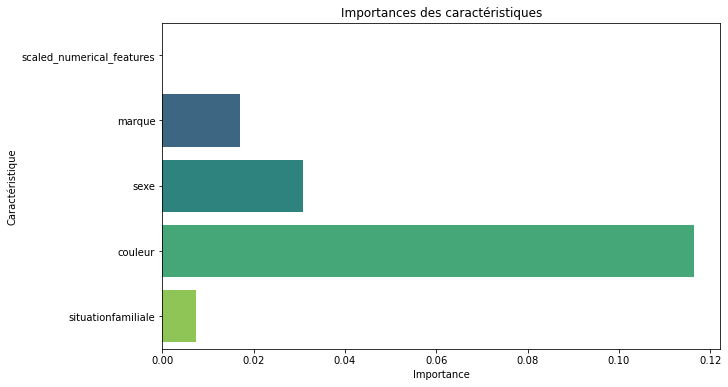

In [29]:
# Supposons que 'model' soit votre modèle entraîné
importances = model.featureImportances

# Noms des caractéristiques
feature_names = ['scaled_numerical_features', 'marque', 'sexe', 'couleur', 'situationfamiliale']

# Afficher les importances des caractéristiques
print("Importances des caractéristiques :")
for i, col in enumerate(feature_names):
    print(f"{col}: {importances[i]:.4f}")

# Créer une liste de tuples (nom de la caractéristique, importance)
feature_importances = [(feature_names[i], importances[i]) for i in range(len(feature_names))]

# Créer un DataFrame pandas
df_importances = pd.DataFrame(feature_importances, columns=['Caractéristique', 'Importance'])

# Initialiser la figure
plt.figure(figsize=(10, 6))

# Créer le diagramme en barres
sns.barplot(x='Importance', y='Caractéristique', data=df_importances, palette='viridis')

# Ajouter le titre et les labels
plt.title("Importances des caractéristiques")
plt.xlabel("Importance")
plt.ylabel("Caractéristique")

# Afficher le graphique
plt.show()

Corrélations entre les colonnes numériques et la catégorie :
age: -0.013791333882514332
taux: -0.2518908324714456
nbenfantacharge: -0.376471989894366
puissance: -0.6646592503895292
nbportes: -0.2789698033994513
prix: -0.687898440747515
categorie: 1.0
couleur_indexed: 0.006054287871478583
longueur: 0.10403423973594472


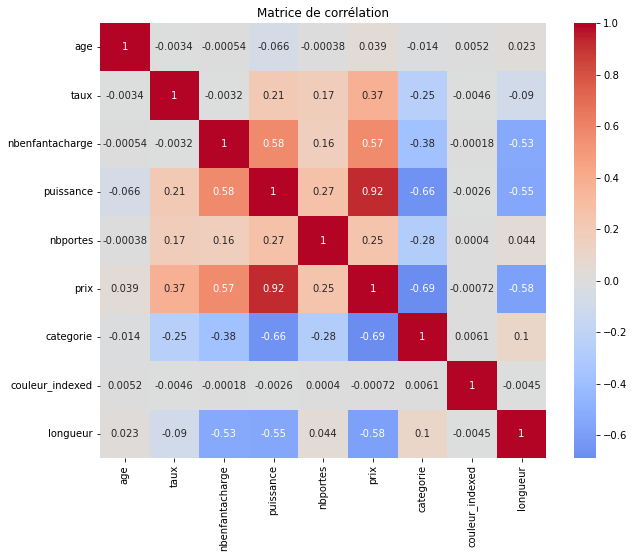

In [30]:
if isinstance(clients_immatriculations.schema["couleur"].dataType, VectorUDT):
    # Extraire la première composante si 'couleur' est un vecteur
    clients_immatriculations = clients_immatriculations.withColumn(
        "couleur_first_component", col("couleur").getItem(0)
    )
    couleur_col = "couleur_first_component"
else:
    # Utiliser StringIndexer si 'couleur' est une chaîne
    indexer = StringIndexer(inputCol="couleur", outputCol="couleur_indexed")
    clients_immatriculations = indexer.fit(clients_immatriculations).transform(clients_immatriculations)
    couleur_col = "couleur_indexed"

# Construire la liste des colonnes numériques
numerical_cols = [
    'age', 'taux', 'nbenfantacharge', 'puissance', 'nbportes', 'prix', 'categorie', couleur_col, 'longueur'
]

# Calcul des corrélations
print("Corrélations entre les colonnes numériques et la catégorie :")
for col_name in numerical_cols:
    correlation = clients_immatriculations.select(corr(col_name, "categorie")).first()[0]
    print(f"{col_name}: {correlation}")

# Conversion en pandas pour la heatmap
df_pandas = clients_immatriculations.select(numerical_cols).toPandas()

# Calcul de la matrice de corrélation
corr_matrix = df_pandas.corr()

# Tracé de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation')
plt.show()

In [31]:
df_final.select("scaled_numerical_features").show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_numerical_features                                                                                                                                        |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.9449358768505604,-1.2473309080800787,-0.8939641042038633,-0.9733097757728637,0.26511664129805995,-1.0365279023544591,1.052242507962002,-0.1650373243627372]   |
|[0.34259417467597864,-0.4362663496169611,1.267359700810678,0.3413374478114725,0.26511664129805995,0.5279562371950479,-1.0934768966408357,-1.1453005079022611]    |
|[0.5616275209212811,-0.6062320842948938,-0.8939641042038633,-1.0463457326386603,-3.7718867602860886,-0.9116337444844288,1.052242507962002,-0.1650373243627372]   |
|[1.656794252147

In [32]:
clients_immatriculations.groupBy('categorie').count().show()

# Taille du jeu de données total
print(f"Taille du jeu de données : {df_final.count()}")

# Taille des ensembles d'entraînement et de test
print(f"Taille de l'ensemble d'entraînement : {trainingData.count()}")
print(f"Taille de l'ensemble de test : {testData.count()}")

+---------+-----+
|categorie|count|
+---------+-----+
|      0.0|36488|
|      1.0|30401|
|      3.0| 5794|
|      2.0|26812|
+---------+-----+

Taille du jeu de données : 99495


Taille de l'ensemble d'entraînement : 79875
Taille de l'ensemble de test : 19620
